# 🧪 GNN Test

Dieses Notebook ist ein erster Test des GNN Ansatzes für die Vorhersage von $\mu$ und $\sigma$

## ✨ Import of Data

In [1]:
# Used to import the helper functions
import sys
sys.path.append('../utils')
from helpers import load_data, load_stations

In [2]:
data = load_data(indexed=False)
# Get List of stations with all -> will break further code if cut already
stations = load_stations(data)
# drop incomplete rows for fist test
data.drop(['sm_mean', 'sm_var'], inplace=True, axis=1)
# drop stations with elevation > 1000
data = data.drop(data[data['alt'] > 1000].index)


In [3]:
# Normalize the data
exclude_cols = ['date', 'obs', 'station','doy']

# normalize the DataFrame, excluding the columns to exclude
normalized_data = data.copy()  # create a copy of the original DataFrame to avoid modifying it directly
for col in data.columns:
    if col not in exclude_cols:
        normalized_data[col] = (data[col] - data[col].mean()) / data[col].std()

## 💽 Create the torch dataset

The Dataset which is a `pandas.DataFrame` gets converted to a `torch_geometric.data` object, which then can be processed by the GNN

#### 🚧 TODO
 - are the distances correct?


In [4]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import geopy.distance
import pandas as pd
import numpy as np
from tqdm import tqdm

In [5]:
def dist_km(lat1, lon1, lat2, lon2):
    """Returns distance bewtween two stations in km using the the WGS-84 ellipsoid.

    Args:
        lat1 (float): latitude of first station
        lat2 (float): latitude of second station
        lon1 (float): longitude of first station
        lon2 (float): longitude of second station

    Returns:
        float: distance in km
    """
    return geopy.distance.geodesic((lat1, lon1), (lat2, lon2)).km


def compute_dist_matrix(df: pd.DataFrame) -> np.array:
    """Returns a distance matrix between stations.

    Args:
        df (pd.DataFrame): dataframe with stations

    Returns:
        np.array: distance matrix
    """
    coords_df = df[['lat', 'lon']].copy()

    # create numpy arrays for latitudes and longitudes
    latitudes = np.array(coords_df['lat'])
    longitudes = np.array(coords_df['lon'])

    # create a meshgrid of latitudes and longitudes
    lat_mesh, lon_mesh = np.meshgrid(latitudes, longitudes)

    # calculate distance matrix using vectorized distance function
    distance_matrix = np.vectorize(dist_km)(lat_mesh, lon_mesh, lat_mesh.T, lon_mesh.T)
    return distance_matrix


def create_data(data: pd.DataFrame, date: pd.Timestamp, mask: np.array, dist_matrix: np.array) -> Data:
    """
    Create a PyTorch Geometric Data object from a given date.

    Args:
        data (pd.DataFrame): dataframe with stations and observations
        date (pd.Timestamp): date to create data for
        mask (np.array): Boolean array that represents the edges with distance less than max_dist
        dist_matrix (np.array): distance matrix between stations


    Returns:
        Data: PyTorch Geometric Data object
    """
    # Get the rows of the dataframe corresponding to the current date
    df = data[data['date'] == date]

    # Get the stations that reported for the current date
    reporting_stations = df['station'].to_numpy()
    assert any(df.station.value_counts() != 1) == False # Any Station that reports data should appear only once
    assert all(reporting_stations[:-1] < reporting_stations[1:]) # Array of Stations should be in ascending order

    # Create feature tensor (stations are orderd in the data)
    node_features = df.drop(['date', 'obs'], axis=1).to_numpy()
    x = torch.tensor(node_features, dtype=torch.float)
    
    # Create target tensor
    target = df['obs'].to_numpy()
    y = torch.tensor(target, dtype=torch.float)

    # Create a pairwise distance matrix (omit non reporting stations)
    mesh = np.ix_(reporting_stations, reporting_stations)
    mask_sliced = mask[mesh]

    # Get the indices of the edges to include
    edges = np.argwhere(mask_sliced)
    edges = edges.T

    edge_index = torch.tensor(edges, dtype=torch.int64)
    assert edge_index.shape[0] == 2
    
    #Create edge_attr tensor
    dist_matrix_sliced = dist_matrix[mesh]
    edge_attr = dist_matrix_sliced[edges[0], edges[1]]
    edge_attr = edge_attr.reshape(-1, 1)
    edge_attr = torch.tensor(edge_attr)
    # Create a PyTorch Geometric Data object
    data = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr)
    return data


In [6]:
dist_matrix = compute_dist_matrix(stations)

# TODO set the maximum distance (might want to get this from a configuration file)
max_dist = 50

# Create a boolean mask indicating which edges to include
mask = (dist_matrix <= max_dist) & (dist_matrix != 0)

In [7]:
torch_data = []

for date in tqdm(data['date'].unique()):
    torch_data.append(create_data(data=normalized_data, date=date, mask=mask, dist_matrix=dist_matrix))

100%|██████████| 3651/3651 [00:30<00:00, 119.17it/s]


### 💿 Dataloaders

In [8]:
# Definition of train_loader and valid_loader
# TODO another hyperparameter here 
train_loader = DataLoader(torch_data[:-730], batch_size=64, shuffle=True)
valid_loader = DataLoader(torch_data[-730:-365], batch_size=64, shuffle=True)
test_data = torch_data[-365:]
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

### 👀 Visualizations of Graph to test if everything worked fine
Currently not working because data is scaled

In [9]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline
plt.style.use('default')

In [10]:
def visualize_graph(d: Data):
    G = to_networkx(d, to_undirected=True)
    pos =  d.x[:,-5:-3].detach().numpy() # TODO this does not work if new features are added (add dict featureToIndex)
    pos = np.transpose([pos[:, 1], pos[:, 0]]) # Switch latitude and longitude
    # Rescale lat and long
    fac_lat = data["lat"].std()
    fac_lon = data["lon"].std()
    mean_lat = data["lat"].mean()
    mean_lon = data["lon"].mean()
    pos = pos * np.array([fac_lon, fac_lat]) + np.array([mean_lon, mean_lat])
    
    dict_pos = {i: p.tolist() for i, p in enumerate(pos)}
    
    # Plot map
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.coastlines()
    ax.set_extent([5, 16, 47, 56], crs=proj)
    ax.add_feature(cfeature.LAND, color="lightgrey")
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.OCEAN)

    # Colors 
    color_values = d.edge_attr.flatten()
    cmap = mpl.colormaps.get_cmap('YlGnBu')
    # Normalize the values to range between 0 and 1
    norm = plt.Normalize(min(color_values), max(color_values))
    # Generate a list of colors based on the normalized values
    colors = [cmap(norm(value)) for value in color_values]
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, ax=ax)
    
    # Plot Graph
    nx.draw_networkx(G, pos=dict_pos, node_size=10, node_color="black", ax=ax, with_labels=False, edge_color=colors)
    
    # Fix the aspect ratio of the map
    lat_center = (ax.get_extent()[2] + ax.get_extent()[3]) / 2
    ax.set_aspect(1 / np.cos(np.radians(lat_center)))
    
    ax.set_title("Active weather stations in Germany")
    
    plt.show()

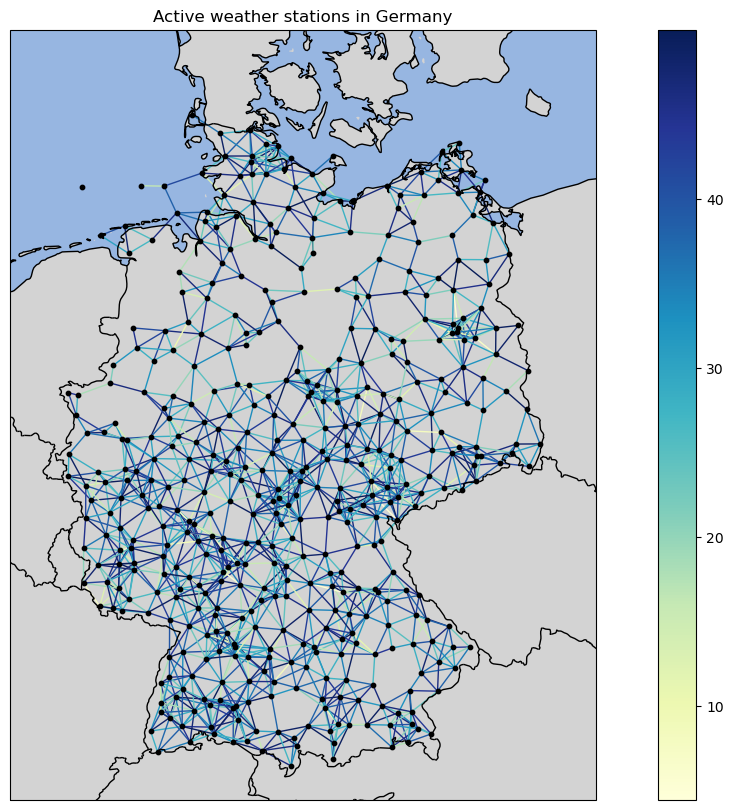

In [11]:
visualize_graph(torch_data[100])

## 🌐 GNN 

In the following section the gnn is constructed. This is largely based on the [PyG Colab Notebooks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing).

#### 🚧 TODO
 - gin config
 - Neural Tension Kernel
 - Attention weights mitteln und anschauen (Kanten in Graph einfärben)
 - W&B hinzufügen
 - Check out GNN explainer
 - Hyperparameter Optimization
 - Test different Layers and Architectures
    - Embed Node ID (wie in paper von Sebastian)
    - ResNet (Reciedial Layer)
    - Softplus for sigma
    - Edge Weights

### 📉 CRPS Loss Function

\begin{align*}

    \operatorname{crps}(F,X)=&\int_{-\inf}^{\inf}\left(F(y)-\boldsymbol{1}_{(y-x)}\right)^2dy\\

\end{align*}

Closed form expression from Gneiting et al. (2005)

\begin{align*}

    \operatorname{crps}\left(\mathcal{N}\left(\mu, \sigma^2\right), y\right)= & \sigma\left\{\frac{y-\mu}{\sigma}\left[2 \Phi\left(\frac{y-\mu}{\sigma}\right)-1\right] +2 \varphi\left(\frac{y-\mu}{\sigma}\right)-\frac{1}{\sqrt{\pi}}\right\}

\end{align*}

$\Phi\left(\frac{y-\mu}{\sigma}\right)$ denotes the CDF of a standard normal distribution and $\varphi\left(\frac{y-\mu}{\sigma}\right)$ denotes the PDF of a standard normal distribution

In [12]:
def crps(mu: torch.tensor, sigma: torch.tensor, y: torch.tensor):
    """Calculates the Continuous Ranked Probability Score (CRPS) assuming normally distributed data

    Args:
        mu (torch.tensor): mean
        sigma (torch.tensor): standard deviation
        y (torch.tensor): observed data

    Returns:
        torch.tensor: CRPS value
    """
    y = y.view((-1,1)) # make sure y has the right shape
    sigma = torch.abs(sigma)
    PI = 3.14159265359
    omega = (y - mu) / sigma
    # PDF of normal distribution at omega
    pdf = 1/(torch.sqrt(torch.tensor(2 * PI))) * torch.exp(-0.5 * omega ** 2)
    
    # Source: https://stats.stackexchange.com/questions/187828/how-are-the-error-function-and-standard-normal-distribution-function-related
    cdf = 0.5 * (1 + torch.erf(omega / torch.sqrt(torch.tensor(2))))
    
    crps = sigma * (omega * (2 * cdf - 1) + 2 * pdf - 1/torch.sqrt(torch.tensor(PI)))
    return  torch.mean(crps)

### 🕸️ GNN
Definition of Model and Training

In [13]:
from torch.nn import Linear, Embedding, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, summary

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

cuda:0


In [15]:
from torch.nn import Linear, ReLU
from torch_geometric.nn import Sequential, GAT

In [29]:
num_features = torch_data[0].num_features

model = Sequential('x, edge_index', [
    (GAT(in_channels=num_features, hidden_channels=64, num_layers=2, out_channels=512, dropout=0.1), 'x, edge_index -> x'),
    ReLU(inplace=True),
    Linear(512, 2),
    (lambda x: (x[:, :1], x[:, 1:]), 'x -> mu, sigma'),
    (lambda mu, sigma: (mu, F.softplus(sigma)), 'mu, sigma -> mu, sigma')
])

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.002) #momentum anschauen

In [30]:

#TODO more hyperparams here
n_epochs = 100
patience = 10
best_val_loss = float('inf')
no_improvement = 0

def train(data):
    data.to(device)
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)#, data.edge_attr)
    mu, sigma = out
    loss = crps(mu, sigma, data.y)
    loss.backward()
    optimizer.step()
    return loss

train_losses = []
validation_losses = []

# loading bar
pbar = tqdm(range(n_epochs))

for epoch in pbar:
    # Train for one epoch
    model.train()
    train_loss = 0.0
    for data in train_loader:
        loss = train(data)
        train_loss += loss.item() * data.num_graphs
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
        
    # Evaluate on the validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in valid_loader:
            data.to(device)
            out = model(data.x, data.edge_index)#, data.edge_attr)
            mu, sigma = out
            loss = crps(mu, sigma, data.y)
            val_loss += loss.item() * data.num_graphs
        val_loss /= len(valid_loader.dataset)
        validation_losses.append(val_loss)

    # Print the training and validation loss for each epoch

    # Check if the validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1
    
    pbar.set_postfix({"Train Loss": train_loss, "Val Loss": val_loss, "No Improvement": no_improvement})
    # Early stopping
    if no_improvement == patience:
        print('Early stopping.')
        break

 87%|████████▋ | 87/100 [09:40<01:26,  6.67s/it, Train Loss=0.958, Val Loss=1, No Improvement=10]   

Early stopping.


In [31]:
print(summary(model, x=torch_data[1000].x.to(device), edge_index=torch_data[1000].edge_index.to(device)))#, edge_attr=None))

+--------------------------+----------------------+--------------------+----------+
| Layer                    | Input Shape          | Output Shape       | #Param   |
|--------------------------+----------------------+--------------------+----------|
| Sequential_b2762e        |                      | [499, 1], [499, 1] | 38,082   |
| ├─(module_0)GAT          | [499, 40], [2, 4530] | [499, 512]         | 37,056   |
| │    └─(act)ReLU         | [499, 64]            | [499, 64]          | --       |
| │    └─(convs)ModuleList | --                   | --                 | 37,056   |
| │    │    └─(0)GATConv   | [499, 40], [2, 4530] | [499, 64]          | 2,752    |
| │    │    └─(1)GATConv   | [499, 64], [2, 4530] | [499, 512]         | 34,304   |
| ├─(module_1)ReLU         | [499, 512]           | [499, 512]         | --       |
| ├─(module_2)Linear       | [499, 512]           | [499, 2]           | 1,026    |
+--------------------------+----------------------+--------------------+----

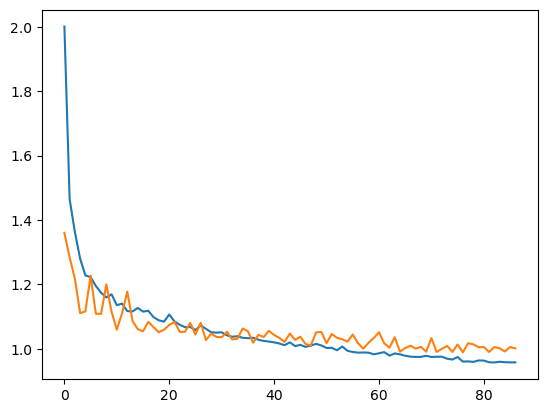

In [32]:
plt.plot(train_losses[1:])
plt.plot(validation_losses[1:])

### 💾 Saving the Model
Every time the model is run a copy of the code and the model parameters are saved

In [ ]:
from datetime import datetime as dt
import shutil
import os

In [ ]:
# Save Model and losses
date = str(dt.now()).replace(":","-").split(".")[0]
path = f"modelsAndVariables/{date}"

if not os.path.exists(path):
    os.makedirs(path)

torch.save(model.state_dict(), f"{path}/model.pt")
train_losses = np.array(train_losses)
np.save(f"{path}/train_losses.npy", train_losses)
validation_losses = np.array(validation_losses)
np.save(f"{path}/test_losses.npy", validation_losses)

dst_folder = path
notebook_name = "gnn_test.ipynb"
shutil.copy(notebook_name, path + "/" + notebook_name)

'modelsAndVariables/2023-05-21 22-30-31/gnn_test.ipynb'

### 🤔 Evaluation
Calculation of CRPS on test set and graphical diagnostics

In [33]:
import numpy as np
model.eval()
mu_list = []
sigma_list = []
err_list = []
y_list = []


for data in test_loader:
    data.to(device)
    mu, sigma = model(data.x, data.edge_index)#, None)
    y = data.y
    err = crps(mu, sigma, y)
    mu = mu.detach().cpu().numpy().flatten()
    sigma = sigma.detach().cpu().numpy().flatten()
    y = y.cpu().numpy()
    err = err.detach().cpu().numpy()

    mu_list.append(mu)
    sigma_list.append(sigma)
    y_list.append(y)
    err_list.append(err*len(data))

err = sum(err_list) / len(test_loader.dataset)
mu = np.concatenate(mu_list)
sigma = np.concatenate(sigma_list)
y = np.concatenate(y_list)

Text(0.5, 1.0, 'Predicted vs. observed temperatures\nCRPS=0.9778')

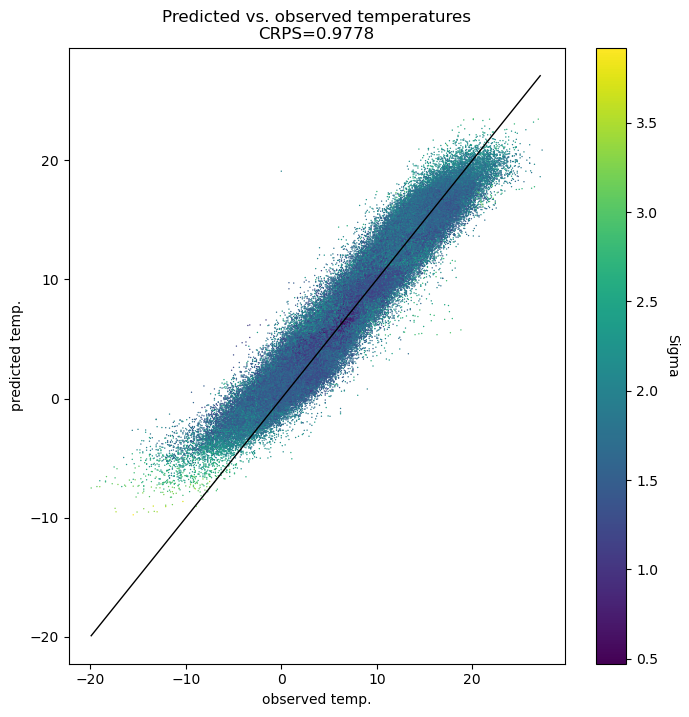

In [34]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(np.min(y),np.max(y),1), np.arange(np.min(y),np.max(y),1), linewidth=1, color="black")
plt.scatter(y, mu, c=sigma, s=1, linewidth=0, cmap="viridis")


cbar = plt.colorbar()
cbar.set_label('Sigma', rotation=270, labelpad=15)
plt.xlabel('observed temp.')
plt.ylabel('predicted temp.')
plt.title(f"Predicted vs. observed temperatures\nCRPS={err:.4f}")